### 할당된 GPU 확인

In [1]:
!nvidia-smi

Tue Jun 15 02:42:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Drive mount

In [2]:
from google.colab import drive
import os, sys

drive.mount('/content/drive')

Mounted at /content/drive


### 필요한 library 및 자료 다운로드

In [3]:
!pip install  mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9MB 104kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 8.8MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595710 sha256=5ec9079fa8c9ff7aea710fe1b4bf0a05357f14edbe52a9818497559692b850dd
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 9.0MB/s 
     |████████████████████████████████| 2.3MB 8.0MB/s 
     |████████████████████████████████| 3.3MB 54.1MB/s 
     |████████████████████████████████| 901kB 59.2MB/s 


In [4]:
#!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-yrtqn9hv
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-yrtqn9hv
  Created wheel for kobert: filename=kobert-0.1.2-cp37-none-any.whl size=12718 sha256=55383ac49d084e8baae6e9045f0d863699bf5fc13ad9f4b4bca6c7813ed692ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-rejmwy4v/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [6]:
from transformers import AdamW, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

### gpu 사용

In [7]:
##GPU 사용 시
device = torch.device("cuda:0")

### Pretrained bert, vocab load

In [8]:
#bertmodel, vocab = get_pytorch_kobert_model()
#bertmodel = get_kobert_model()

model_path = '/content/drive/MyDrive/kobert_from_pretrained'
vocab_file = '/content/drive/MyDrive/kobert_news_wiki_ko_cased-1087f8699e.spiece'
bertmodel = BertModel.from_pretrained(model_path)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file, padding_token='[PAD]')

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### 우리가 사용하는 dataset 가져와서 train, validation, test set으로 분류

In [10]:
file1 = '/content/drive/MyDrive/problem_ner_multilabel_re_addonlykorean_replacevariable_replacenumber.csv'
file2 = '/content/drive/MyDrive/problem_ner_min_re_275_addonlykorean_replacevariable_replacenumber.csv'
file3 = '/content/drive/MyDrive/ner_preprocessed_complete_re_drop_addonlykorean_replacevariable_replacenumber_8_label_single.csv'

In [11]:
df = pd.read_csv(file3)

In [12]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'id', 'tag', 'title', 'description', 'input', 'output', 'ner_decode',
       'list_ner', 'ner_preprocessed_desc', 'only_korean_desc',
       'only_korean_input', 'only_korean_output',
       'only_korean_variablenumber_desc', 'only_korean_variablenumber_input',
       'only_korean_variablenumber_output', 'variablenumber_desc',
       'variablenumber_input', 'variablenumber_output',
       'desc_variabel_renumber', 'input_variabel_renumber',
       'output_variabel_renumber', 'desc_variabel_renumber_0',
       'input_variabel_renumber_0', 'output_variabel_renumber_0'],
      dtype='object')

In [13]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7, stratify = df.tag.values)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5, stratify = remaining.tag.values)

### tag가 string이기 때문에 숫자로 바꾸기 위해서 encoder라는 것을 사용한다
### encoder를 사용하면 쉽게 tag의 문자를 숫자로 바꿔준다

In [14]:
print(train_df.shape, valid_df.shape, test_df.shape)

#라벨의 숫자화
label = df['tag'].values
encoder = LabelEncoder()
encoder.fit(label)

(2842, 31) (609, 31) (609, 31)


LabelEncoder()

### label별 data 개수가 불균형한 경우 학습에 영향을 주기 때문에 loss 가중치를 조정하여 해결할 수도 있다
### 우리 학습할 땐 사용 안했음

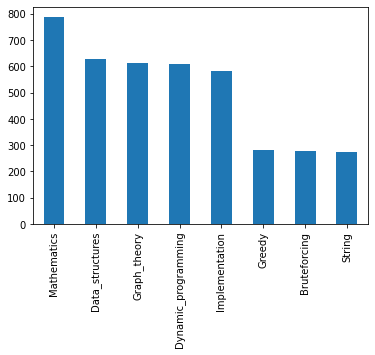

['Bruteforcing' 'Data_structures' 'Dynamic_programming' 'Graph_theory'
 'Greedy' 'Implementation' 'Mathematics' 'String']
tensor([1.8255, 0.8068, 0.8333, 0.8279, 1.7933, 0.8690, 0.6440, 1.8388])


In [15]:
df.tag.value_counts().plot(kind='bar')
plt.show()

class_loss = [df.tag.value_counts()[i] for i in encoder.classes_ ]
class_weights = compute_class_weight('balanced', np.unique(df['tag']), df['tag'])
weights= torch.tensor(class_weights,dtype=torch.float)
print(encoder.classes_)
print(weights)

In [16]:
### 분류한 dataset을 형식에 맞게 변환하는 코드

In [17]:
def set_data(dataframe) :
  dataset = []
  tmp = encoder.transform(dataframe['tag'])
  i = 0
  for index, row in dataframe.iterrows():
   problem = row['desc_variabel_renumber_0']
   if not pd.isna(row['input_variabel_renumber_0']) :
      problem = problem + row['input_variabel_renumber_0']

   dataset.append([problem , tmp[i]])
   i = i + 1
  return dataset

In [18]:
dataset_train = set_data(train_df)
dataset_valid = set_data(valid_df)
dataset_test = set_data(test_df)

### tokenizer는 문장을 단어로 나눠주는 역할을 한다

In [20]:
#tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(vocab_file, vocab, lower=False)

### 데이터셋 관련 코드

In [21]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


### model parameter


In [22]:
## Setting parameters
max_len = 512
batch_size = 8
warmup_ratio = 0.1
num_epochs = 8
max_grad_norm = 1
log_interval = 100
learning_rate =  5e-5

### 데이터 셋 표준화 과정

In [23]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_valid = BERTDataset(dataset_valid, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [42]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=4)

### 우리가 사용할 모델 정의 
### bert 모델 뒤에 single layer 추가해서 softmax로 분류하는 방식

In [25]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 layers = 2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.hidden_dim = 384
        self.layers = layers

        self.classifier = nn.Linear(self.hidden_dim, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
        self.lstm = nn.LSTM(
          input_size = hidden_size,
          hidden_size= self.hidden_dim,
          num_layers = self.layers, 
          dropout = dr_rate,
          batch_first = True,
          bidirectional=True
        )
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        op, _ = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        _, (out, _) = self.lstm(op)
        out = out[-1]
        if self.dr_rate:
            out = self.dropout(out)
        return self.classifier(out)

### model 할당

In [26]:
model = BERTClassifier(bertmodel, num_classes=8, dr_rate=0.1, layers=1).to(device) 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [27]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01}, #0.01
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0} #0.0
]

### optimizer와 loss function 설정

In [28]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight = weights).to(device)
#loss_fn = nn.CrossEntropyLoss()

### 잘 모르겠음 ;;

In [29]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [30]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

### 정확도 계산하는 함수

In [31]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# train 시키는 코드

In [33]:
train_loss_values = []
validation_loss_values = [] 
train_acc_list = []
validation_acc_list = []
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    validation_loss = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(train_loss)
    train_acc_list.append(train_acc / len(train_dataloader))

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)

        validation_loss += loss.item() 
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    validation_loss = validation_loss / len(valid_dataloader)
    validation_loss_values.append(validation_loss)
    validation_acc_list.append(test_acc / len(valid_dataloader))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


epoch 1 batch id 1 loss 2.050440788269043 train acc 0.125
epoch 1 batch id 101 loss 2.2466044425964355 train acc 0.1670792079207921
epoch 1 batch id 201 loss 1.9923062324523926 train acc 0.20708955223880596
epoch 1 batch id 301 loss 2.105652332305908 train acc 0.20390365448504982

epoch 1 train acc 0.21207865168539325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.33766233766233766


epoch 2 batch id 1 loss 1.9302458763122559 train acc 0.25
epoch 2 batch id 101 loss 1.9304509162902832 train acc 0.27970297029702973
epoch 2 batch id 201 loss 1.7439743280410767 train acc 0.30286069651741293
epoch 2 batch id 301 loss 1.960976481437683 train acc 0.2857142857142857

epoch 2 train acc 0.29353932584269665



epoch 2 test acc 0.36038961038961037


epoch 3 batch id 1 loss 1.9470806121826172 train acc 0.25
epoch 3 batch id 101 loss 1.9087620973587036 train acc 0.3626237623762376
epoch 3 batch id 201 loss 1.4450136423110962 train acc 0.361318407960199
epoch 3 batch id 301 loss 1.831405520439148 train acc 0.3579734219269103

epoch 3 train acc 0.36973314606741575



epoch 3 test acc 0.349025974025974


epoch 4 batch id 1 loss 1.6701394319534302 train acc 0.375
epoch 4 batch id 101 loss 1.8558045625686646 train acc 0.4467821782178218
epoch 4 batch id 201 loss 1.455706000328064 train acc 0.44029850746268656
epoch 4 batch id 301 loss 1.755232334136963 train acc 0.4435215946843854

epoch 4 train acc 0.45435393258426965



epoch 4 test acc 0.38636363636363635


epoch 5 batch id 1 loss 1.2494251728057861 train acc 0.5
epoch 5 batch id 101 loss 1.7237908840179443 train acc 0.5185643564356436
epoch 5 batch id 201 loss 1.0555039644241333 train acc 0.5149253731343284
epoch 5 batch id 301 loss 1.6552822589874268 train acc 0.5261627906976745

epoch 5 train acc 0.5410814606741573



epoch 5 test acc 0.37662337662337664


epoch 6 batch id 1 loss 1.260330080986023 train acc 0.5
epoch 6 batch id 101 loss 1.2739163637161255 train acc 0.6163366336633663
epoch 6 batch id 201 loss 0.6364239454269409 train acc 0.6225124378109452
epoch 6 batch id 301 loss 1.4296571016311646 train acc 0.6403654485049833

epoch 6 train acc 0.6530898876404494



epoch 6 test acc 0.3652597402597403


epoch 7 batch id 1 loss 1.083553433418274 train acc 0.625
epoch 7 batch id 101 loss 1.162284016609192 train acc 0.7264851485148515
epoch 7 batch id 201 loss 0.31255877017974854 train acc 0.7201492537313433
epoch 7 batch id 301 loss 0.7698813080787659 train acc 0.731312292358804

epoch 7 train acc 0.7387640449438202



epoch 7 test acc 0.36363636363636365


epoch 8 batch id 1 loss 0.9340593218803406 train acc 0.5
epoch 8 batch id 101 loss 0.8540387153625488 train acc 0.7970297029702971
epoch 8 batch id 201 loss 0.2763250768184662 train acc 0.7786069651741293
epoch 8 batch id 301 loss 0.5797494053840637 train acc 0.7919435215946844

epoch 8 train acc 0.7981039325842697



epoch 8 test acc 0.3652597402597403


### loss graph 그린다

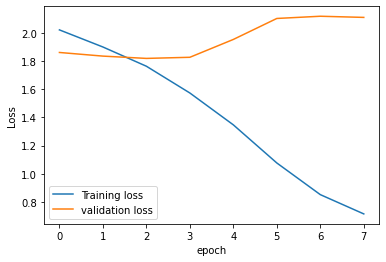

In [34]:
plt.plot(np.array(train_loss_values), label='Training loss')
plt.plot(np.array(validation_loss_values), label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 정확도 graph 그림

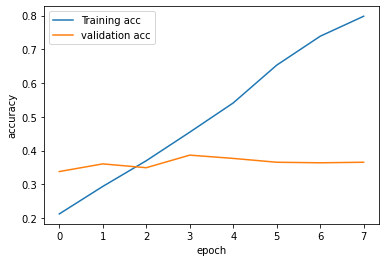

In [35]:
plt.plot(np.array(train_acc_list), label='Training acc')
plt.plot(np.array(validation_acc_list), label='validation acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### predict하는 코드

In [43]:
pred_list = []
test_label = []

with torch.no_grad():
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    test_label.extend(label)
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    _, pred_value = torch.max(out, 1)
    pred_list.extend(pred_value.cpu().numpy())

pred_list = [a.squeeze().tolist() for a in pred_list]
test_label = [a.squeeze().tolist() for a in test_label]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


### 알고리즘별 정확도 출력하는 코드
#### precision : label이 a일 때 a라고 예측한 확률
#### recall : a라고 예측했을 때, a인 확률
#### f1-score : recall과 precision의 조화평균
#### support : 개수
#### 관점에 따라 사용하는 것이 다르다고 생각하면 됨 

In [44]:
target_name = encoder.classes_
print(classification_report(test_label, pred_list, target_names=target_name, zero_division = 0))

                     precision    recall  f1-score   support

       Bruteforcing       0.02      0.02      0.02        42
    Data_structures       0.53      0.46      0.49        94
Dynamic_programming       0.30      0.38      0.34        91
       Graph_theory       0.58      0.55      0.57        92
             Greedy       0.19      0.24      0.21        42
     Implementation       0.31      0.26      0.28        88
        Mathematics       0.52      0.47      0.50       118
             String       0.47      0.50      0.48        42

           accuracy                           0.39       609
          macro avg       0.36      0.36      0.36       609
       weighted avg       0.41      0.39      0.40       609



### y축 = input x축 = 예측 결과, 대각선의 확률이 a일 때 a로 예측한 확률

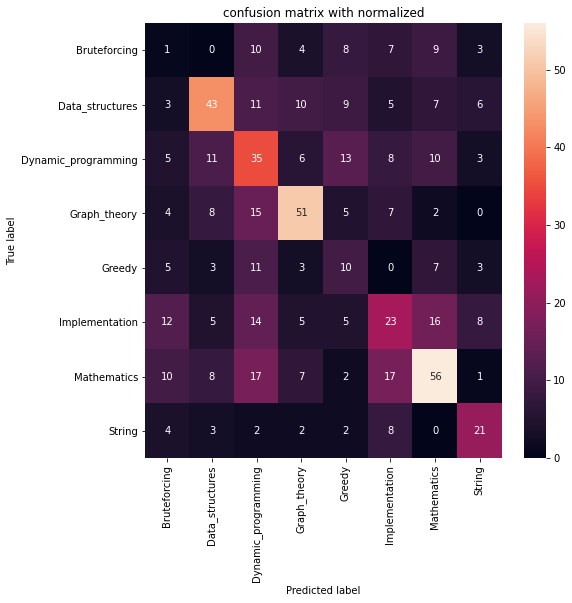

In [46]:
cm = confusion_matrix(test_label, pred_list)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, target_name, target_name)
plt.figure(figsize=(8, 8))
plt.title('confusion matrix with normalized')
sn.heatmap(df_cm, annot = True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()